In [1]:
import deepsensor.torch
from deepsensor.data import DataProcessor, TaskLoader
from deepsensor.model import ConvNP
from deepsensor.train import Trainer

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm import notebook
from deepsensor.train import set_gpu_default_device
from xarray.groupers import TimeResampler

import torch

import subprocess
import time
import wandb

In [2]:
import wandb

entity = "saiavu-university-of-michigan"
project = "deepsensor-greatlakes"
alias = "latest"  # semantic nickname or identifier for the model version
model_artifact_name = "trained-model"

# Initialize a run
run = wandb.init()
# Access and download model. Returns path to downloaded artifact
wb_path = "{}/{}/{}:{}".format(entity, project, model_artifact_name, alias)
downloaded_model_path = run.use_model(name=wb_path)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: saiavu (saiavu-university-of-michigan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb:   2 of 2 files downloaded.  


In [3]:
def transform_ice(da):
    da = xr.DataArray(da)  # Ensure input is always an xarray.DataArray
    nan_mask = da.isnull()  # This correctly creates a mask in xarray
    transformed = xr.where(da > 0.2, 0, 1)  # Apply thresholding
    transformed = transformed.where(~nan_mask, np.nan)  # Preserve NaNs
    return transformed

set_gpu_default_device()
scratch_path = "/scratch/dannes_root/dannes0/saiavu"

start_year = 2007
end_year = 2023
start_dt = str(start_year) + "-01-01T12:00:00.000000000"
end_dt = str(end_year) + "-12-31T12:00:00.000000000"

bathymetry_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/bathymetry/interpolated_bathymetry.nc'
mask_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/masks/lakemask.nc'

mask = xr.open_dataset(mask_path)
bath = xr.open_dataset(bathymetry_path)


fpath = [f'/nfs/turbo/seas-dannes/SST-sensor-placement-input/GLSEA3_NETCDF/GLSEA3_{date}.nc' for date in range(start_year, end_year+1)]

# Load dataset using xarray with chunking
glsea3_raw = xr.open_mfdataset(
    fpath, combine="by_coords", parallel=True, chunks={"time": 3, "lat": 512, "lon": 512}
).drop_vars('crs', errors="ignore")

# Apply transform_ice function while keeping it as xarray
ice_mask = xr.apply_ufunc(
    transform_ice,
    glsea3_raw["sst"],  # Ensure function applies only to 'sst' DataArray
    dask="allowed",  # Ensures correct Dask processing
    output_dtypes=[glsea3_raw["sst"].dtype],
    keep_attrs=True,  # Preserve metadata
)

ice_mask = ice_mask.rename("binary_ice_indicator")

#glsea3_new = xr.apply_ufunc(transform_nan, glsea3_raw, dask="allowed", output_dtypes=[glsea3_raw["sst"].dtype])
glsea3_new = glsea3_raw.where(np.isnan(glsea3_raw.sst) == False, -0.009) 

climatology = glsea3_new.groupby("time.dayofyear").mean("time")

anomalies = glsea3_new.groupby("time.dayofyear") - climatology

anomalies = anomalies.chunk({"time": 3, "lat": 512, "lon": 512})
ice_mask = ice_mask.chunk({"time": 3, "lat": 512, "lon": 512})



data_processor = DataProcessor(x1_name="lat", x2_name="lon")

mask_ds = data_processor(mask)

bath_ds = data_processor(bath)

_ = data_processor(anomalies.sel(time = slice("2007-01-01T12:00:00.000000000", "2007-04-01T12:00:00.000000000")))
anom_ds = data_processor(anomalies)

_ = data_processor(ice_mask.sel(time = slice("2007-01-01T12:00:00.000000000", "2007-04-01T12:00:00.000000000")))
ice_ds = data_processor(ice_mask)

data_processor.save(scratch_path + "/deepsensor_config/")


In [4]:
task_loader = TaskLoader(
    context = [anom_ds, mask_ds, bath_ds, ice_ds],
    target = anom_ds, 
)

In [5]:
print(task_loader)

TaskLoader(4 context sets, 1 target sets)
Context variable IDs: (('sst',), ('mask',), ('bathymetry',), ('binary_ice_indicator',))
Target variable IDs: (('sst',),)


In [6]:
model_loaded = ConvNP(data_processor, task_loader, "artifacts/trained-model:v16/")

In [7]:
model_loaded

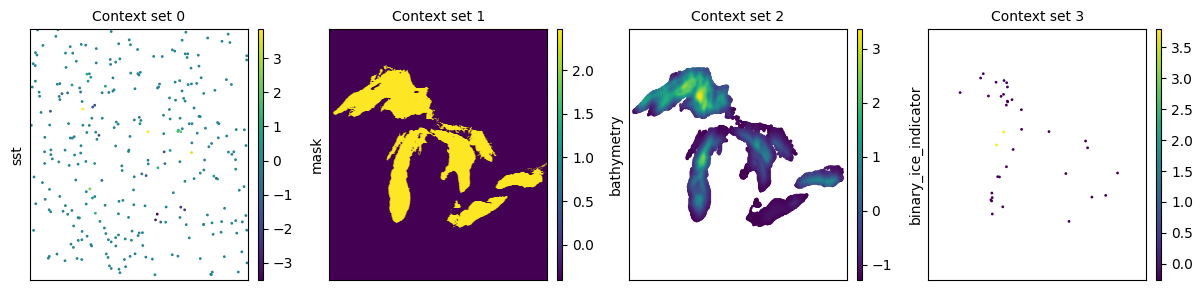

In [8]:
date = "2023-01-03T12:00:00"
test_task = task_loader(date, [300, "all", "all", 300])

fig = deepsensor.plot.task(test_task, task_loader)
plt.show()

In [21]:
pred = model_loaded.predict(test_task, X_t=mask)

In [22]:
pred["sst"]

<xarray.Dataset> Size: 8MB
Dimensions:  (time: 1, lat: 838, lon: 1181)
Coordinates:
  * lat      (lat) float64 7kB 38.87 38.89 38.9 38.92 ... 50.58 50.59 50.61
  * lon      (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
  * time     (time) datetime64[ns] 8B 2023-01-03T12:00:00
Data variables:
    mean     (time, lat, lon) float32 4MB -0.007626 0.0005332 ... -0.0208
    std      (time, lat, lon) float32 4MB 0.06028 0.06014 ... 0.04539 0.04436

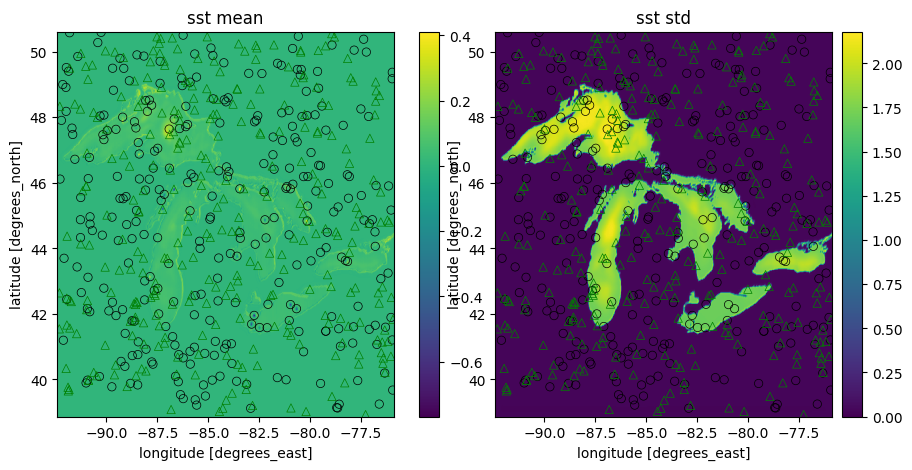

In [24]:
fig2 = deepsensor.plot.prediction(pred, date, data_processor, task_loader, test_task)
plt.show()

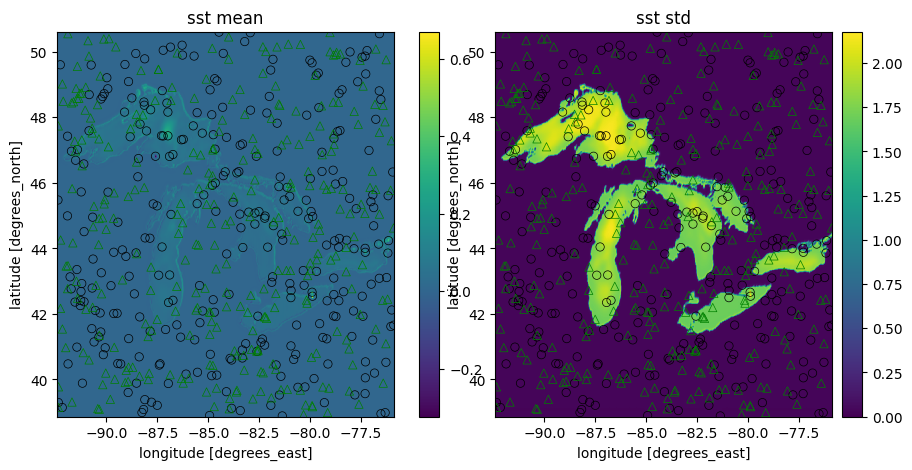

In [30]:
date = "2023-05-03T12:00:00"
test_task = task_loader(date, [300, "all", "all", 300])

pred = model_loaded.predict(test_task, X_t=mask)

fig3 = deepsensor.plot.prediction(pred, date, data_processor, task_loader, test_task)
plt.show()


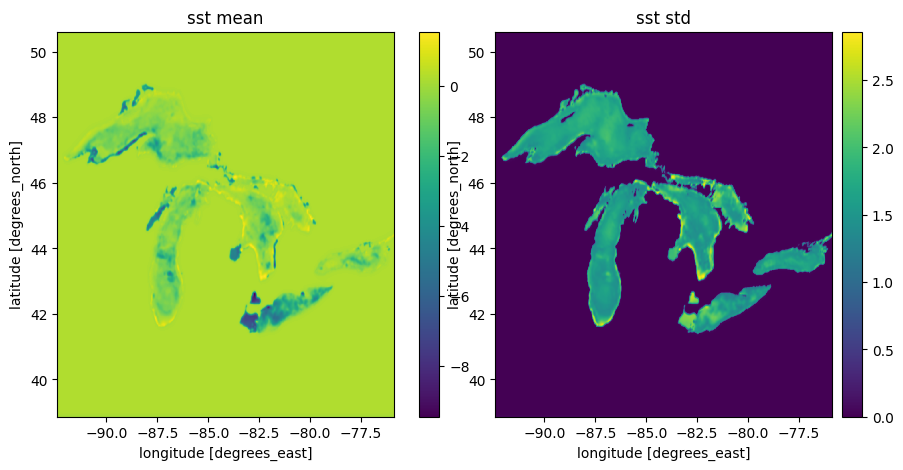

In [31]:
date = "2023-01-03T12:00:00"
test_task = task_loader(date, context_sampling = ["all", "all", "all", "all"], target_sampling = "all")

pred = model_loaded.predict(test_task, X_t=mask)

fig4 = deepsensor.plot.prediction(pred, date, data_processor, task_loader, test_task)
plt.show()

In [39]:
# Predict at two off-grid locations with 200 random context points (fixed across time)
test_tasks = task_loader(pd.date_range("2023-01-01T12:00:00", "2023-5-20T12:00:00"), [200, "all", "all", 200], seed_override=42)

KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

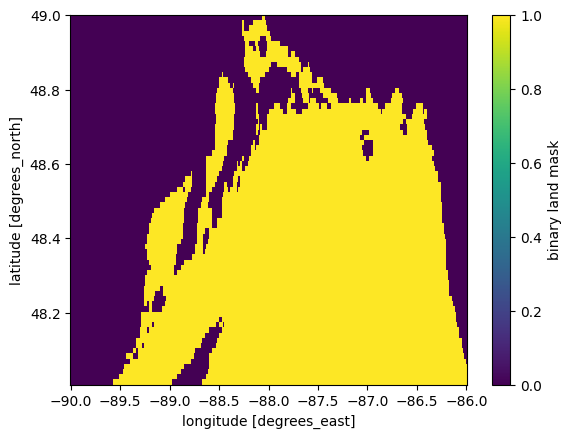

In [30]:
temp = mask.sel(lat = slice(48, 49), lon = slice(-90, -86))["mask"]
temp.plot()
plt.show()

In [63]:
#pred = model_loaded.predict(test_tasks, X_t= temp)
X_t = np.array([[42.82, -87.5],
                [48.6, -88.0]]).T
pred = model_loaded.predict(test_tasks, X_t= X_t)

In [64]:
pred["sst"]

mean       std
time                lat   lon                      
2022-01-01 12:00:00 42.82 -87.5  0.045468  1.775721
                    48.60 -88.0  0.048402  1.900163
2022-01-02 12:00:00 42.82 -87.5  0.045468  1.775721
                    48.60 -88.0  0.048402  1.900163
2022-01-03 12:00:00 42.82 -87.5  0.045466  1.775721
...                                   ...       ...
2022-05-18 12:00:00 48.60 -88.0  0.048402  1.900163
2022-05-19 12:00:00 42.82 -87.5  0.045468  1.775721
                    48.60 -88.0  0.048402  1.900163
2022-05-20 12:00:00 42.82 -87.5  0.045468  1.775721
                    48.60 -88.0  0.048402  1.900163

[280 rows x 2 columns]

In [ ]:
pred["sst"] = pred["sst"][["time", "lat", "lon", "mean", "std"]]
pred["sst"]

/home/saiavu/deepsensor_sai/lib/python3.10/site-packages/deepsensor/plot.py:1027: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/home/saiavu/deepsensor_sai/lib/python3.10/site-packages/deepsensor/plot.py:1027: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


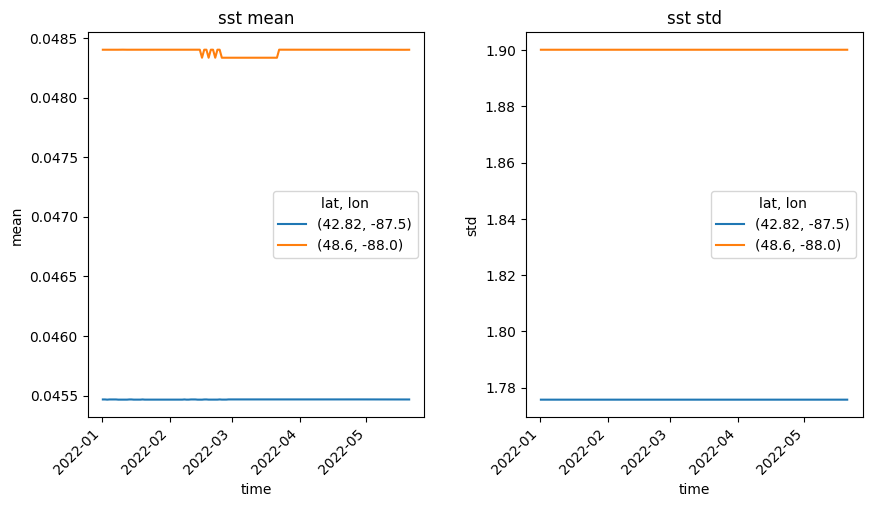

In [66]:
fig = deepsensor.plot.prediction(pred)
fig